# Fissio Base - Power Plant Data Explorer

This notebook connects to the seeded DuckDB database containing:
- **WRI Global Power Plant Database** (34,936 plants worldwide)
- **NRC Reactor Status** (last 365 days)
- **US Nuclear Plants** summary tables

In [1]:
import duckdb

# Connect to the seeded database
con = duckdb.connect('/home/jovyan/data/fissio.duckdb', read_only=True)
print("Connected to fissio.duckdb")

Connected to fissio.duckdb


## Available Tables

In [2]:
con.sql("""
    SELECT table_schema, table_name, table_type
    FROM information_schema.tables
    WHERE table_schema IN ('plants', 'regulatory', 'market')
    ORDER BY table_schema, table_name
""").show()

┌──────────────┬─────────────────────┬────────────┐
│ table_schema │     table_name      │ table_type │
│   varchar    │       varchar       │  varchar   │
├──────────────┼─────────────────────┼────────────┤
│ market       │ generation_summary  │ BASE TABLE │
│ plants       │ global_power_plants │ BASE TABLE │
│ plants       │ us_nuclear_plants   │ BASE TABLE │
│ plants       │ us_plants_summary   │ BASE TABLE │
│ plants       │ v_nuclear_plants    │ VIEW       │
│ plants       │ v_us_power_plants   │ VIEW       │
│ regulatory   │ nrc_reactor_status  │ BASE TABLE │
└──────────────┴─────────────────────┴────────────┘



## Global Power Plants by Fuel Type

In [3]:
con.sql("""
    SELECT 
        primary_fuel,
        COUNT(*) as plant_count,
        ROUND(SUM(capacity_mw), 0) as total_mw,
        ROUND(AVG(capacity_mw), 1) as avg_mw
    FROM plants.global_power_plants
    GROUP BY primary_fuel
    ORDER BY total_mw DESC
""").show()

┌────────────────┬─────────────┬───────────┬────────┐
│  primary_fuel  │ plant_count │ total_mw  │ avg_mw │
│    varchar     │    int64    │  double   │ double │
├────────────────┼─────────────┼───────────┼────────┤
│ Coal           │        2330 │ 1965541.0 │  843.6 │
│ Gas            │        3998 │ 1493051.0 │  373.4 │
│ Hydro          │        7156 │ 1053160.0 │  147.2 │
│ Nuclear        │         195 │  407912.0 │ 2091.9 │
│ Wind           │        5344 │  263054.0 │   49.2 │
│ Oil            │        2320 │  261879.0 │  112.9 │
│ Solar          │       10665 │  188312.0 │   17.7 │
│ Biomass        │        1430 │   34281.0 │   24.0 │
│ Waste          │        1068 │   14749.0 │   13.8 │
│ Geothermal     │         189 │   12688.0 │   67.1 │
│ Cogeneration   │          41 │    4048.0 │   98.7 │
│ Other          │          43 │    3613.0 │   84.0 │
│ Petcoke        │          12 │    2425.0 │  202.0 │
│ Storage        │         135 │    1712.0 │   12.7 │
│ Wave and Tidal │          

## US Nuclear Plants

In [4]:
con.sql("""
    SELECT name, capacity_mw, commissioning_year, owner
    FROM plants.us_nuclear_plants
    ORDER BY capacity_mw DESC
    LIMIT 20
""").show()

┌───────────────────────────────┬─────────────┬────────────────────┬─────────────────────────────────┐
│             name              │ capacity_mw │ commissioning_year │              owner              │
│            varchar            │   double    │       double       │             varchar             │
├───────────────────────────────┼─────────────┼────────────────────┼─────────────────────────────────┤
│ Palo Verde                    │      4209.6 │ 1986.6666666666665 │ Arizona Public Service Co       │
│ Browns Ferry                  │      3494.0 │  1975.351459645106 │ Tennessee Valley Authority      │
│ Peach Bottom                  │      2876.4 │  1974.478723404255 │ Exelon Nuclear                  │
│ Turkey Point                  │      2861.2 │ 1987.5449461764294 │ Florida Power & Light Co        │
│ South Texas Project           │      2708.6 │             1988.5 │ STP Nuclear Operating Co        │
│ Oconee                        │      2666.7 │  1974.002474969063 │ Duke

## NRC Reactor Status (Recent)

In [5]:
con.sql("""
    SELECT *
    FROM regulatory.nrc_reactor_status
    LIMIT 20
""").show()

┌─────────────────────┬─────────────────────────────┬───────┐
│      ReportDt       │            Unit             │ Power │
│      timestamp      │           varchar           │ int64 │
├─────────────────────┼─────────────────────────────┼───────┤
│ 2026-02-04 00:00:00 │ Arkansas Nuclear 1          │   100 │
│ 2026-02-04 00:00:00 │ Arkansas Nuclear 2          │   100 │
│ 2026-02-04 00:00:00 │ Beaver Valley 1             │   100 │
│ 2026-02-04 00:00:00 │ Beaver Valley 2             │   100 │
│ 2026-02-04 00:00:00 │ Braidwood 1                 │   100 │
│ 2026-02-04 00:00:00 │ Braidwood 2                 │   100 │
│ 2026-02-04 00:00:00 │ Browns Ferry 1              │   100 │
│ 2026-02-04 00:00:00 │ Browns Ferry 2              │   100 │
│ 2026-02-04 00:00:00 │ Browns Ferry 3              │    97 │
│ 2026-02-04 00:00:00 │ Brunswick 1                 │    99 │
│ 2026-02-04 00:00:00 │ Brunswick 2                 │   100 │
│ 2026-02-04 00:00:00 │ Byron 1                     │   100 │
│ 2026-0

## Power Plants Near a Location

Find plants within ~100km of a given latitude/longitude.

In [6]:
# Example: Plants near Chicago (41.88, -87.63)
lat, lon = 41.88, -87.63

con.sql(f"""
    SELECT 
        name,
        primary_fuel,
        capacity_mw,
        ROUND(latitude, 2) as lat,
        ROUND(longitude, 2) as lon
    FROM plants.global_power_plants
    WHERE country = 'USA'
      AND ABS(latitude - {lat}) < 1.0
      AND ABS(longitude - {lon}) < 1.0
    ORDER BY capacity_mw DESC
    LIMIT 15
""").show()

┌────────────────────────────────────┬──────────────┬─────────────┬────────┬────────┐
│                name                │ primary_fuel │ capacity_mw │  lat   │  lon   │
│              varchar               │   varchar    │   double    │ double │ double │
├────────────────────────────────────┼──────────────┼─────────────┼────────┼────────┤
│ Braidwood Generation Station       │ Nuclear      │      2449.8 │  41.24 │ -88.23 │
│ R M Schahfer                       │ Coal         │      2201.4 │  41.22 │ -87.03 │
│ Dresden Generating Station         │ Nuclear      │      2018.6 │  41.39 │ -88.27 │
│ Elwood Energy LLC                  │ Gas          │      1728.0 │  41.44 │ -88.12 │
│ Elm Road Generating Station        │ Coal         │      1402.6 │  42.85 │ -87.83 │
│ Joliet 29                          │ Gas          │      1320.0 │  41.49 │ -88.12 │
│ Kendall County Generation Facility │ Gas          │      1256.0 │  41.48 │ -88.26 │
│ South Oak Creek                    │ Coal         │ 

## Export to Pandas (for visualization)

In [7]:
# Convert to pandas DataFrame
df = con.sql("""
    SELECT primary_fuel, SUM(capacity_mw) as total_mw
    FROM plants.global_power_plants
    GROUP BY primary_fuel
    ORDER BY total_mw DESC
""").df()

df.head(10)

,primary_fuel,total_mw
0,Coal,1.965541e+06
1,Gas,1.493051e+06
2,Hydro,1.053160e+06
3,Nuclear,4.079118e+05
4,Wind,2.630537e+05
5,Oil,2.618787e+05
6,Solar,1.883123e+05
7,Biomass,3.428130e+04
8,Waste,1.474871e+04
9,Geothermal,1.268775e+04


<Axes: title={'center': 'Global Capacity by Fuel Type (MW)'}, ylabel='primary_fuel'>

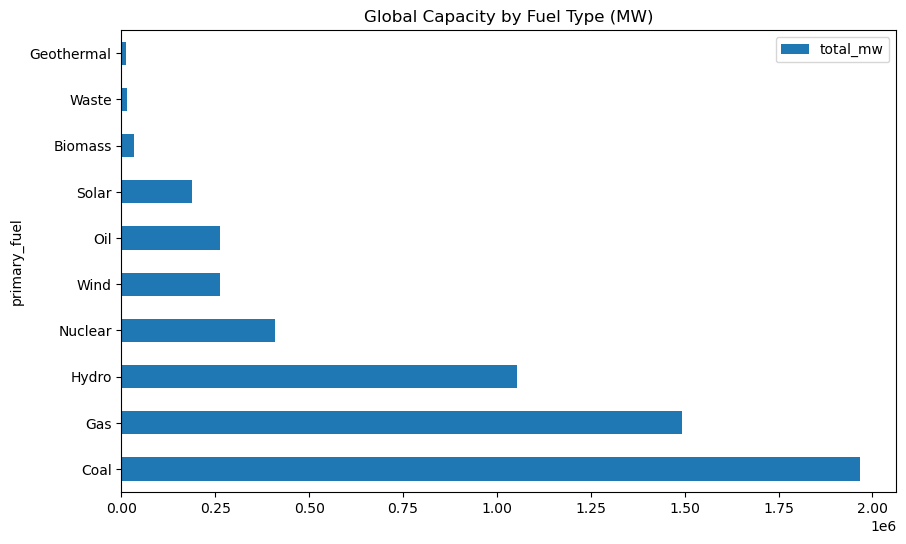

In [8]:
# Simple bar chart
df.set_index('primary_fuel').head(10).plot(kind='barh', figsize=(10, 6), title='Global Capacity by Fuel Type (MW)')